In [ ]:
# 코랩 환경 한글 글꼴 설치, 설치 후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (19.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121654 files and direc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# [1] 데이터, 라이브러리 로드

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score


from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Attention, LayerNormalization, Dropout, BatchNormalization, GRU
from keras.callbacks import EarlyStopping

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/data/train.csv',encoding = 'utf-8')
final = pd.read_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/data/test.csv',encoding = 'utf-8')
sub = pd.read_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/data/sample_submission.csv',encoding = 'utf-8')

In [ ]:
data = train.copy()
test = final.copy()

# 2. 데이터 전처리

## 2.1 피쳐 전처리

- 대출기간

In [ ]:
test.대출기간.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [ ]:
data['대출기간'] = data['대출기간'].str[0:3]
test['대출기간'] = test['대출기간'].str[0:3]

- 근로기간

In [ ]:
data.근로기간.unique()

array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
       '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

In [ ]:
test.근로기간.unique()

array(['8 years', '5 years', '6 years', 'Unknown', '10+ years', '3 years',
       '< 1 year', '1 year', '7 years', '4 years', '2 years', '9 years',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

In [ ]:
def map_work_duration(value):
    mapping = {
        '6 years': 6,
        '10+ years': 15,
        '5 years': 5,
        '8 years': 8,
        'Unknown': np.nan,
        '9 years': 9,
        '2 years': 2,
        '1 year': 1,
        '3 years': 3,
        '7 years': 7,
        '4 years': 4,
        '< 1 year': 0.5,
        '10+years': 15,
        '<1 year': 0.5,
        '3': 3,
        '1 years': 1
    }
    return mapping.get(value, np.nan)

data['근로기간'] = data['근로기간'].apply(map_work_duration)

data.근로기간.unique()

array([ 6. , 15. ,  5. ,  8. ,  nan,  9. ,  2. ,  1. ,  3. ,  7. ,  4. ,
        0.5])

In [ ]:
test['근로기간'] = test['근로기간'].apply(map_work_duration)

test.근로기간.unique()

array([ 8. ,  5. ,  6. ,  nan, 15. ,  3. ,  0.5,  1. ,  7. ,  4. ,  2. ,
        9. ])



- 주택소유상태, 대출목적 (라벨 인코딩)

In [ ]:
list(data['주택소유상태'].unique())

['RENT', 'MORTGAGE', 'OWN', 'ANY']

In [ ]:
mode_house = data['주택소유상태'].mode()[0]

test['주택소유상태'] = np.where(test['주택소유상태'].isin(data['주택소유상태'].unique()),
                                  test['주택소유상태'],
                                  mode_house)

In [ ]:
mode_purpose = data['대출목적'].mode()[0]

test['대출목적'] = np.where(test['대출목적'].isin(data['대출목적'].unique()),
                                  test['대출목적'],
                                  mode_purpose)

In [ ]:
le_house = LabelEncoder()
le_purpose = LabelEncoder()

In [ ]:
data['주택소유상태'] = le_house.fit_transform(data['주택소유상태'])
data['대출목적'] = le_purpose.fit_transform(data['대출목적'])

test['주택소유상태'] = le_house.transform(test['주택소유상태'])
test['대출목적'] = le_purpose.transform(test['대출목적'])

In [ ]:
# '주택소유상태' 매핑
house_label_mapping = dict(zip(le_house.classes_, le_house.transform(le_house.classes_)))
print("주택소유상태 매핑:", house_label_mapping)

# '대출목적' 매핑
purpose_label_mapping = dict(zip(le_purpose.classes_, le_purpose.transform(le_purpose.classes_)))
print("대출목적 매핑:", purpose_label_mapping)

주택소유상태 매핑: {'ANY': 0, 'MORTGAGE': 1, 'OWN': 2, 'RENT': 3}
대출목적 매핑: {'기타': 0, '부채 통합': 1, '소규모 사업': 2, '신용 카드': 3, '의료': 4, '이사': 5, '자동차': 6, '재생 에너지': 7, '주요 구매': 8, '주택': 9, '주택 개선': 10, '휴가': 11}


- 매출등급 매핑

```
A -> 0
B -> 1
C -> 2
D -> 3
E -> 4
F -> 5
G -> 6
```

In [ ]:
mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}

reverse_mapping = {v: k for k, v in mapping.items()}

data['대출등급'] = data['대출등급'].map(mapping)
data.대출등급

## 2.2 NA 처리
    - 근로기간 NA 존재

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          90623 non-null  float64
 4   주택소유상태        96294 non-null  int64  
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  int64  
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  int64  
dtypes: float64(5), int64(8), object(2)
memory usage: 11.0+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64197 entries, 0 to 64196
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            64197 non-null  object 
 1   대출금액          64197 non-null  int64  
 2   대출기간          64197 non-null  object 
 3   근로기간          60335 non-null  float64
 4   주택소유상태        64197 non-null  int64  
 5   연간소득          64197 non-null  int64  
 6   부채_대비_소득_비율   64197 non-null  float64
 7   총계좌수          64197 non-null  int64  
 8   대출목적          64197 non-null  int64  
 9   최근_2년간_연체_횟수  64197 non-null  int64  
 10  총상환원금         64197 non-null  int64  
 11  총상환이자         64197 non-null  float64
 12  총연체금액         64197 non-null  float64
 13  연체계좌수         64197 non-null  float64
dtypes: float64(5), int64(7), object(2)
memory usage: 6.9+ MB


- 상관관계가 높은 총계좌수별 최빈값으로 대치

In [ ]:
correlation_matrix = data.corr()
correlation_matrix['근로기간'].sort_values(ascending=False)

<ipython-input-69-128eb5a32355>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


근로기간            1.000000
총계좌수            0.100987
대출금액            0.089096
연간소득            0.055853
총상환이자           0.049638
부채_대비_소득_비율     0.042879
총상환원금           0.024094
최근_2년간_연체_횟수    0.023206
대출목적            0.014986
연체계좌수           0.003475
총연체금액           0.003227
대출등급           -0.021946
주택소유상태         -0.204966
Name: 근로기간, dtype: float64

In [ ]:
mean_work = data.groupby('총계좌수')['근로기간'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

data['근로기간'] = data.apply(
    lambda row: mean_work[row['총계좌수']] if pd.isna(row['근로기간']) else row['근로기간'],
    axis=1
)

mean_work_2 = test.groupby('총계좌수')['근로기간'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)


test['근로기간'] = test.apply(
    lambda row: mean_work_2[row['총계좌수']] if pd.isna(row['근로기간']) else row['근로기간'],
    axis=1
)

- 이후에도 NA값은 최빈값으로 대치

In [ ]:
mode_values = data.mode().iloc[0]
mode_values_2 = test.mode().iloc[0]

data = data.fillna(mode_values)
test = test.fillna(mode_values_2)

## 2.3 스케일링

In [ ]:
scaler = MinMaxScaler()

scaled_columns = scaler.fit_transform(data[['대출금액', '대출기간', '근로기간', '연간소득',
                                               '부채_대비_소득_비율', '총계좌수', '총상환원금',
                                               '총상환이자', '총연체금액', '연체계좌수']])

scaled_columns_2 = scaler.transform(test[['대출금액', '대출기간', '근로기간', '연간소득',
                                               '부채_대비_소득_비율', '총계좌수', '총상환원금',
                                               '총상환이자', '총연체금액', '연체계좌수']])

In [ ]:
data[['대출금액', '대출기간', '근로기간', '연간소득', '부채_대비_소득_비율',
         '총계좌수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']] = scaled_columns

test[['대출금액', '대출기간', '근로기간', '연간소득', '부채_대비_소득_비율',
         '총계좌수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']] = scaled_columns_2

## 2.4 학습용 데이터 완성

In [ ]:
data_target = data.대출등급

data.drop(['ID', '대출등급'], axis = 1, inplace = True)
test.drop(['ID'], axis = 1, inplace = True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data, data_target,stratify = data_target, random_state = 42)

# 3. 학습

## 3.1 RandomForest

- 학습

In [ ]:
rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

- 검증

In [ ]:
rf_predictions = rf_classifier.predict(X_val)

rf_f1_score = f1_score(y_val, rf_predictions, average='macro')

In [ ]:
print("Random Forest F1 Score:", rf_f1_score)

Random Forest F1 Score: 0.6519020633190152


- 예측

In [ ]:
final_rf_predictions = rf_classifier.predict(test)
final_rf_predictions

array([1, 1, 0, ..., 2, 2, 0])

In [ ]:
sub['대출등급'] = final_rf_predictions
sub

,ID,대출등급
0,TEST_00000,1
1,TEST_00001,1
2,TEST_00002,0
3,TEST_00003,2
4,TEST_00004,2
...,...,...
64192,TEST_64192,2
64193,TEST_64193,3
64194,TEST_64194,2
64195,TEST_64195,2


## 3.2 LightGBM

In [ ]:
lgbm_classifier = LGBMClassifier()

lgbm_classifier.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1514
[LightGBM] [Info] Number of data points in the train set: 72220, number of used features: 13
[LightGBM] [Info] Start training from score -1.747688
[LightGBM] [Info] Start training from score -1.206422
[LightGBM] [Info] Start training from score -1.248762
[LightGBM] [Info] Start training from score -1.975633
[LightGBM] [Info] Start training from score -2.572245
[LightGBM] [Info] Start training from score -3.897179
[LightGBM] [Info] Start training from score -5.434900


LGBMClassifier()

In [ ]:
lgbm_predictions = lgbm_classifier.predict(X_val)

lgbm_f1_score = f1_score(y_val, lgbm_predictions, average='macro')

In [ ]:
print("LightGBM F1 Score:", lgbm_f1_score)

LightGBM F1 Score: 0.7621710360853827


- 예측

In [ ]:
final_lgbm_predictions = lgbm_classifier.predict(test)
final_lgbm_predictions

array([1, 1, 0, ..., 3, 2, 0])

In [ ]:
sub['대출등급'] = final_lgbm_predictions

sub['대출등급'] = sub['대출등급'].map(reverse_mapping)

sub.to_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/submission/sub_1.csv', index = False) # 0.782

## 3.3 XGBoost

In [ ]:
xgb_classifier = XGBClassifier()

xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
xgb_predictions = xgb_classifier.predict(X_val)

xgb_f1_score = f1_score(y_val, xgb_predictions, average='macro')

In [ ]:
print("XGBoost F1 Score:", xgb_f1_score)

XGBoost F1 Score: 0.7883713664821632


- 예측

In [ ]:
final_xgb_predictions = xgb_classifier.predict(test)
final_xgb_predictions

array([1, 1, 0, ..., 3, 2, 0])

In [ ]:
sub['대출등급'] = final_xgb_predictions

sub['대출등급'] = sub['대출등급'].map(reverse_mapping)

sub.to_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/submission/sub_2.csv', index = False) # 0.788

## 3.4 Catboost

In [ ]:
cat_classifier = CatBoostClassifier(verbose=0)  # verbose=0 to silence the training output

cat_classifier.fit(X_train, y_train)

In [ ]:
cat_predictions = cat_classifier.predict(X_val)

cat_f1_score = f1_score(y_val, cat_predictions, average='macro')

In [ ]:
print("CatBoost F1 Score:", cat_f1_score)

CatBoost F1 Score: 0.7385673287254345


- 예측

In [ ]:
final_cat_predictions = cat_classifier.predict(test)
final_cat_predictions

array([[1],
       [1],
       [0],
       ...,
       [3],
       [2],
       [0]])

In [ ]:
sub['대출등급'] = final_cat_predictions

sub['대출등급'] = sub['대출등급'].map(reverse_mapping)

sub.to_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/submission/sub_3.csv', index = False) # 0.757

## 3.5 MLP

In [ ]:
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)

In [ ]:
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))


model.add(Dense(50, activation='relu'))


model.add(Dense(32, activation='relu'))


model.add(Dense(20, activation='relu'))

model.add(Dense(10, activation='relu'))
model.add(BatchNormalization(epsilon = 0.01))
model.add(Dropout(0.2))

model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 64)                896       
                                                                 
 dense_48 (Dense)            (None, 50)                3250      
                                                                 
 dense_49 (Dense)            (None, 32)                1632      
                                                                 
 dense_50 (Dense)            (None, 20)                660       
                                                                 
 dense_51 (Dense)            (None, 10)                210       
                                                                 
 batch_normalization_27 (Ba  (None, 10)                40        
 tchNormalization)                                               
                                                      

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience = 40,  mode='min', restore_best_weights=True)

history = model.fit(X_train, y_train_encoded, epochs= 500, batch_size = 32, validation_data=(X_val, y_val_encoded),
                    callbacks=[early_stopping])

Epoch 1/500
2257/2257 [==============================] - 18s 7ms/step - loss: 1.3722 - accuracy: 0.4259 - val_loss: 1.2426 - val_accuracy: 0.4350
Epoch 2/500
2257/2257 [==============================] - 8s 3ms/step - loss: 1.0098 - accuracy: 0.5815 - val_loss: 0.7920 - val_accuracy: 0.6905
Epoch 3/500
2257/2257 [==============================] - 11s 5ms/step - loss: 0.8546 - accuracy: 0.6492 - val_loss: 0.7579 - val_accuracy: 0.7002
Epoch 4/500
2257/2257 [==============================] - 8s 4ms/step - loss: 0.8048 - accuracy: 0.6762 - val_loss: 0.8941 - val_accuracy: 0.5868
Epoch 5/500
2257/2257 [==============================] - 10s 5ms/step - loss: 0.7776 - accuracy: 0.6852 - val_loss: 0.6395 - val_accuracy: 0.7491
Epoch 6/500
2257/2257 [==============================] - 11s 5ms/step - loss: 0.7519 - accuracy: 0.6968 - val_loss: 0.6039 - val_accuracy: 0.7639
Epoch 7/500
2257/2257 [==============================] - 8s 4ms/step - loss: 0.7261 - accuracy: 0.7091 - val_loss: 0.6002 - va

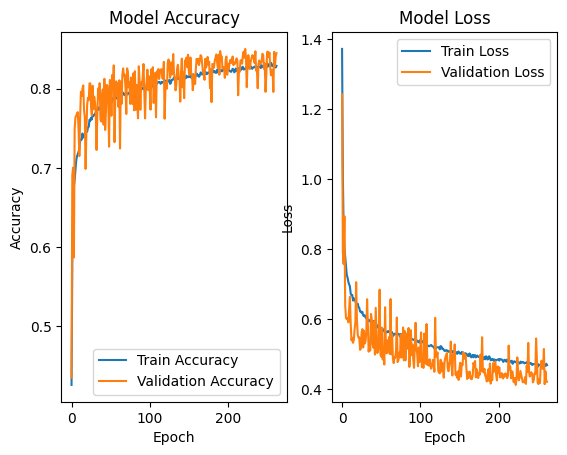

In [ ]:
# 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 추이 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_val_predictions = model.predict(X_val)

y_val_predictions_classes = np.argmax(y_val_predictions, axis=1)

753/753 [==============================] - 2s 2ms/step


In [ ]:
f1 = f1_score(y_val, y_val_predictions_classes, average='macro')

print("F1 Score (Macro):", f1)

F1 Score (Macro): 0.8071879292154319


- 예측

In [ ]:
final_mlp_predictions =  model.predict(test)

y_test_predictions_classes = np.argmax(final_mlp_predictions, axis=1)

y_test_predictions_classes

2007/2007 [==============================] - 4s 2ms/step


array([1, 1, 0, ..., 3, 2, 0])

In [ ]:
sub['대출등급'] = final_cat_predictions

sub['대출등급'] = sub['대출등급'].map(reverse_mapping)

sub.to_csv('/content/drive/MyDrive/Dacon/24_대출고객분류/submission/sub_4.csv', index = False) # 0.7571483277